In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.pipeline import Pipeline
from itertools import combinations
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.naive_bayes import MultinomialNB, ComplementNB, BernoulliNB

### Extraction Features

In [2]:
df = pd.read_csv("../PreProcessing/processed_data/Resume_proc_lemm.csv")

In [3]:
tfidf_vect = TfidfVectorizer(
    lowercase=True,
    binary=False,
    max_features=10000,             # come prima, valuta se serve
    ngram_range=(1, 6),             # unigrams fino a 6-grams
    max_df=0.7,
    min_df=1
)

In [4]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(df['Resume_str'], df['Category'], test_size=0.2, random_state=42, stratify=df['Category'])

print("Train data size:", X_train.shape)
print("Validation data size:", X_test.shape)

Train data size: (1986,)
Validation data size: (497,)


In [5]:
X_train_features = tfidf_vect.fit_transform(X_train)
X_test_features = tfidf_vect.transform(X_test)

In [6]:
len(tfidf_vect.vocabulary_)

10000

### Support Vector Classifier

In [7]:
def report(results, n_top=5):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results["rank_test_score"] == i)
        for candidate in candidates:
            print(f"Model with rank: {i}")
            print(f"Mean validation score: {results['mean_test_score'][candidate]:.3f} (std: {results['std_test_score'][candidate]:.3f})")
            print(f"Parameters: {results['params'][candidate]}")
            print("")

In [8]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [9]:
# SMOTE
class_counts = y_train.value_counts()
min_classes = class_counts[class_counts < class_counts.mean()].index.tolist()

print(f"Applicazione di SMOTE alle classi: {min_classes}")

target_size = int(class_counts.max())
sampling_strategy = {cls: target_size for cls in min_classes}

Applicazione di SMOTE alle classi: ['ARTS', 'TEACHER', 'APPAREL', 'DIGITAL-MEDIA', 'AGRICULTURE', 'AUTOMOBILE', 'BPO']


In [10]:
# Pipeline: TF-IDF + Scaling + Smote + SVM
pipeline = Pipeline([
    #('tfidf', tfidf_vect),
    ('smote', SMOTE(sampling_strategy=sampling_strategy, random_state=42)),
    ('clf', MultinomialNB())
])

In [11]:
nb_classifiers = {
    'MNB': MultinomialNB(),
    'CNB': ComplementNB()
}

param_grid = [
    {
        'clf': [nb_classifiers['MNB']],
        'clf__alpha': [0.1, 0.5, 1.0],
        'clf__fit_prior': [True, False]
    },
    {
        'clf': [nb_classifiers['CNB']],
        'clf__alpha': [0.1, 0.5, 1.0],
        'clf__fit_prior': [True, False]
    }
]

grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=skf,
    scoring='f1_weighted',
    n_jobs=-1,
    return_train_score=True
)

start = time()
grid_search = grid.fit(X_train_features, y_train)

print(f"GridSearchCV took {(time() - start):.2f} seconds for {len(grid_search.cv_results_['params'])} candidates parameter settings.\n")
report(grid_search.cv_results_)

GridSearchCV took 4.74 seconds for 12 candidates parameter settings.

Model with rank: 1
Mean validation score: 0.577 (std: 0.011)
Parameters: {'clf': ComplementNB(), 'clf__alpha': 0.1, 'clf__fit_prior': True}

Model with rank: 1
Mean validation score: 0.577 (std: 0.011)
Parameters: {'clf': ComplementNB(), 'clf__alpha': 0.1, 'clf__fit_prior': False}

Model with rank: 3
Mean validation score: 0.565 (std: 0.013)
Parameters: {'clf': ComplementNB(), 'clf__alpha': 0.5, 'clf__fit_prior': True}

Model with rank: 3
Mean validation score: 0.565 (std: 0.013)
Parameters: {'clf': ComplementNB(), 'clf__alpha': 0.5, 'clf__fit_prior': False}

Model with rank: 5
Mean validation score: 0.560 (std: 0.015)
Parameters: {'clf': ComplementNB(), 'clf__alpha': 1.0, 'clf__fit_prior': True}

Model with rank: 5
Mean validation score: 0.560 (std: 0.015)
Parameters: {'clf': ComplementNB(), 'clf__alpha': 1.0, 'clf__fit_prior': False}



In [12]:
results = pd.DataFrame(grid_search.cv_results_)

# Calcola la differenza tra train e validation scores
results['overfit_gap'] = results['mean_train_score'] - results['mean_test_score']

# Ora puoi:
# - Ordinare per "overfit_gap" crescente
# - Oppure selezionare i modelli che hanno "overfit_gap" più basso
results_sorted = results.sort_values(by='overfit_gap')

# Mostra i primi
results_sorted[['params', 'mean_train_score', 'mean_test_score', 'overfit_gap']].head(10)

,params,mean_train_score,mean_test_score,overfit_gap
4,"{'clf': MultinomialNB(), 'clf__alpha': 1.0, 'c...",0.708398,0.514150,0.194248
5,"{'clf': MultinomialNB(), 'clf__alpha': 1.0, 'c...",0.734495,0.536642,0.197852
10,"{'clf': ComplementNB(), 'clf__alpha': 1.0, 'cl...",0.780636,0.560308,0.220328
11,"{'clf': ComplementNB(), 'clf__alpha': 1.0, 'cl...",0.780636,0.560308,0.220328
8,"{'clf': ComplementNB(), 'clf__alpha': 0.5, 'cl...",0.793653,0.565190,0.228463
9,"{'clf': ComplementNB(), 'clf__alpha': 0.5, 'cl...",0.793653,0.565190,0.228463
2,"{'clf': MultinomialNB(), 'clf__alpha': 0.5, 'c...",0.768256,0.537905,0.230352
3,"{'clf': MultinomialNB(), 'clf__alpha': 0.5, 'c...",0.780230,0.545976,0.234254
6,"{'clf': ComplementNB(), 'clf__alpha': 0.1, 'cl...",0.814299,0.576945,0.237354
7,"{'clf': ComplementNB(), 'clf__alpha': 0.1, 'cl...",0.814299,0.576945,0.237354


In [13]:
print(grid_search.best_params_)

{'clf': ComplementNB(), 'clf__alpha': 0.1, 'clf__fit_prior': True}


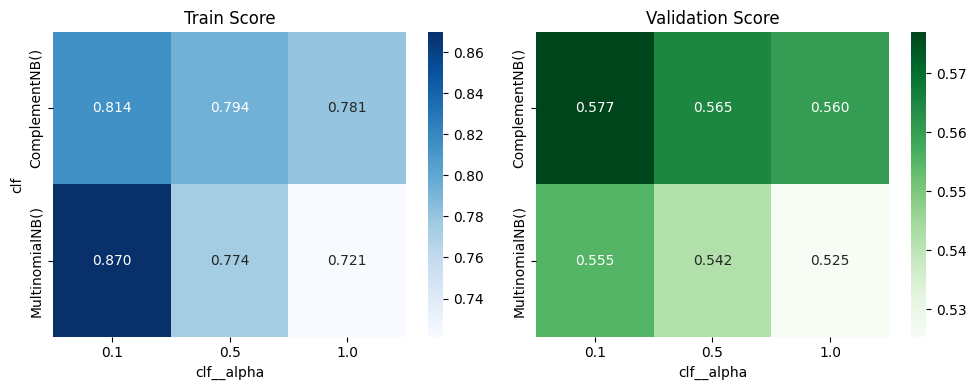

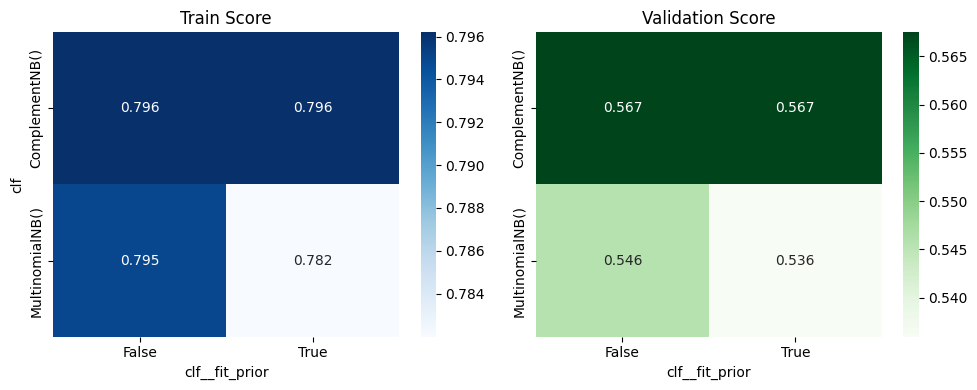

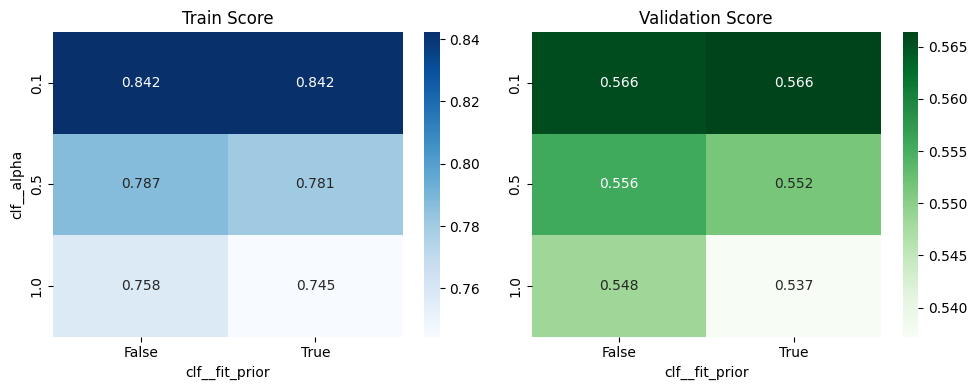

In [14]:
# DataFrame con i risultati
param_cols = [col for col in results.columns if col.startswith("param_")]

# Converti tutti i parametri in stringa per la pivot table
for p in param_cols:
    results[p] = results[p].astype(str)

# Heatmap per ogni coppia di parametri
for p1, p2 in combinations(param_cols, 2):
    try:
        pivot_val = results.pivot_table(values='mean_test_score', index=p1, columns=p2)
        pivot_train = results.pivot_table(values='mean_train_score', index=p1, columns=p2)

        if pivot_val.shape[0] > 1 and pivot_val.shape[1] > 1:
            fig, axes = plt.subplots(1, 2, figsize=(10, 4))

            sns.heatmap(pivot_train, annot=True, fmt=".3f", cmap="Blues", ax=axes[0])
            axes[0].set_title(f"Train Score")
            axes[0].set_xlabel(p2.replace("param_", ""))
            axes[0].set_ylabel(p1.replace("param_", ""))

            sns.heatmap(pivot_val, annot=True, fmt=".3f", cmap="Greens", ax=axes[1])
            axes[1].set_title(f"Validation Score")
            axes[1].set_xlabel(p2.replace("param_", ""))
            axes[1].set_ylabel("")

            plt.tight_layout()
            plt.show()
    except Exception as e:
        print(f"Errore con {p1} e {p2}: {e}")

In [15]:
NB_Model_best = grid_search.best_estimator_
prediction = NB_Model_best.predict(X_test_features)

In [16]:
print("Training Score: {:.2f}".format(NB_Model_best.score(X_train_features, y_train)))
print("Test Score: {:.2f}".format(NB_Model_best.score(X_test_features, y_test)))

Training Score: 0.79
Test Score: 0.65


In [17]:

print(classification_report(y_test, prediction, zero_division=0))

                        precision    recall  f1-score   support

            ACCOUNTANT       0.48      0.88      0.62        24
              ADVOCATE       0.64      0.38      0.47        24
           AGRICULTURE       0.83      0.77      0.80        13
               APPAREL       0.80      0.21      0.33        19
                  ARTS       0.83      0.24      0.37        21
            AUTOMOBILE       0.56      0.71      0.62         7
              AVIATION       0.82      0.75      0.78        24
               BANKING       0.87      0.57      0.68        23
                   BPO       0.50      0.50      0.50         4
  BUSINESS-DEVELOPMENT       0.55      0.88      0.68        24
                  CHEF       0.78      0.88      0.82        24
          CONSTRUCTION       0.77      0.77      0.77        22
            CONSULTANT       1.00      0.04      0.08        23
              DESIGNER       0.82      0.86      0.84        21
         DIGITAL-MEDIA       0.73      

<Figure size 1500x1000 with 0 Axes>

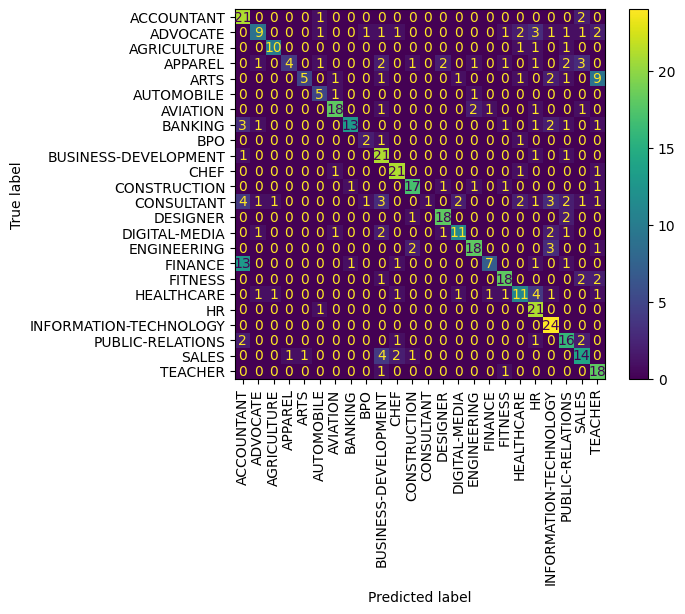

In [18]:
plt.figure(figsize=(15, 10))  # Imposta la dimensione della figura
ConfusionMatrixDisplay.from_predictions(y_test, prediction)
plt.xticks(rotation=90)
plt.show()

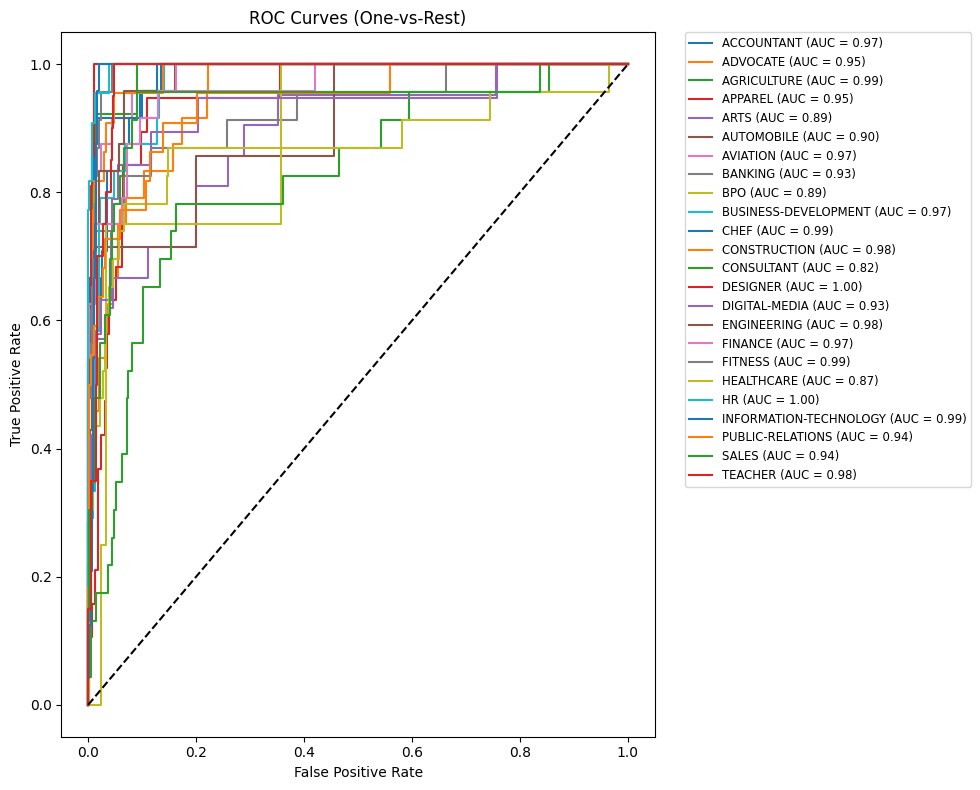

In [19]:
y_test_bin = label_binarize(y_test, classes=NB_Model_best.classes_)
y_score = NB_Model_best.predict_proba(X_test_features)

plt.figure(figsize=(10, 8))

for i in range(len(NB_Model_best.classes_)):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{NB_Model_best.classes_[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (One-vs-Rest)")

# Sposta la legenda fuori dal grafico
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize='small')
plt.tight_layout()
plt.show()

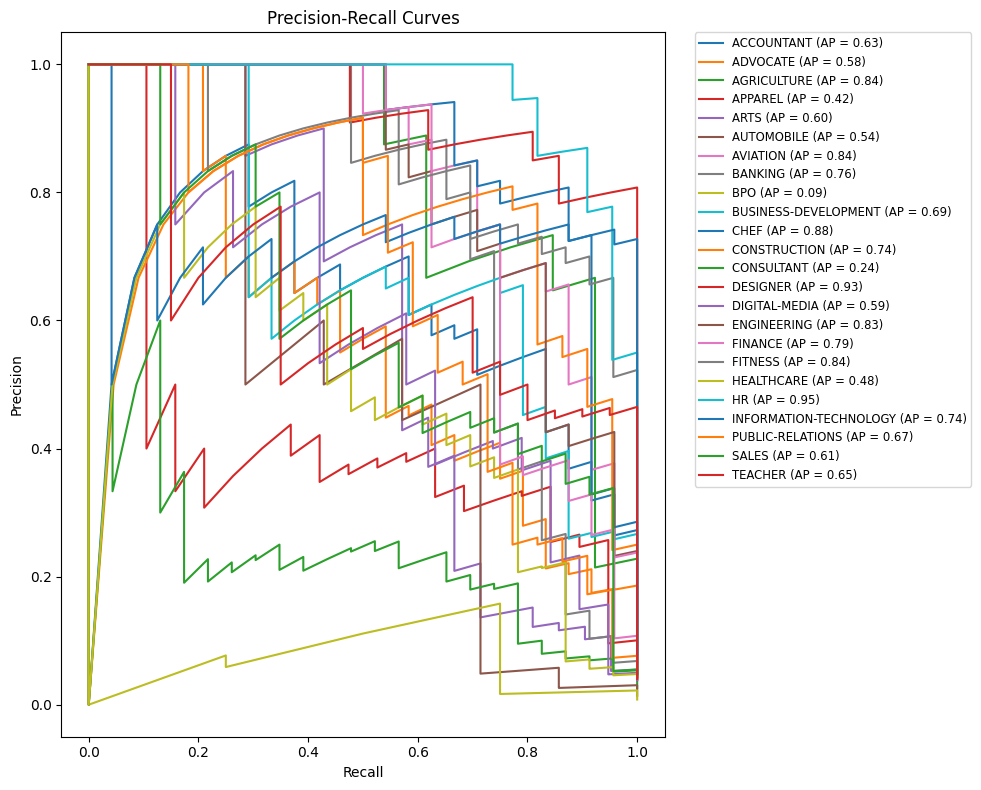

In [20]:
plt.figure(figsize=(10, 8))

for i in range(len(NB_Model_best.classes_)):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
    avg_precision = average_precision_score(y_test_bin[:, i], y_score[:, i])
    plt.plot(recall, precision, label=f"{NB_Model_best.classes_[i]} (AP = {avg_precision:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves")

# Legenda esterna a destra
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize='small')
plt.tight_layout()
plt.show()

In [21]:
import sys
sys.path.append('..')

from utils import save_experiment_TFIDF

save_experiment_TFIDF(tfidf_vect, grid_search, NB_Model_best, X_train_features, y_train, X_test_features, y_test)

✅ Riga di log aggiunta in 'experiment_log.txt':
ComplementNB(clf=ComplementNB(), clf__alpha=0.1, clf__fit_prior=True) | TFIDF(max_features=10000, ngram_range=(1, 6), max_df=0.7, min_df=1) | Accuracy train=0.791, test=0.650

